The log-rank statistic models random variation in the survival statistics of a population due to finite sampling effects.


In [1]:
from typing import List, Union
import pandas as pd
import numpy as np
np.random.seed(1236)

import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)

import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

The Kaplan-Meier (KM) method is one way to estimate the survival curve $S(t)$ of a population based on observed event and censoring times. The method is extremely simple -- below we will implement the method using numpy in two lines of code. The basic idea is that the probability of survival $S(t)$ at each time point $t$ is a free parameter to be estimated subject to the condition that
    $$S(t+\Delta t) = S(t)P(\text{survive to }t + \Delta t|\text{survive to }t)$$

One question that often comes up when computing KM survival curves is whether two curves are significantly different. For instance, we may have two groups of patients, each group on a different medication, and we want to know if the groups have different chances of survival. The log-rank test is one commonly-applied technique to address this question. In this post, we will give a visual demonstration of this key statistical test.

## Problem Setup

We start by simulating patient data with a known survival curve. Since KM is a non-parametric method, let's at least use a survival curve that's complex enough to not be simply modelled by an exponential. An interesting example is a survival curve in which the initial hazard rate is quite large, but over time the hazard decreases, as illustrated below. This example could be applicable to a medication in which most patients experience severe side effects early on, but over time the risk for severe events decreases.

In [2]:
#| include: true

def sigmoid(x):
    return 1./(1 + np.exp(-x))

def generate_two_phase_hazard(
    rate_1: float,
    rate_2: float,
    transition_time: int, 
    transition_dur: int,
    observation_time: int):
    
    # divide by 2 between the window is symmetric about the transition time
    transition_dur = transition_dur / 2 
    
    time = np.linspace(0, observation_time, observation_time + 1)
    hazard = \
        rate_1 * sigmoid(-(time - transition_time) / transition_dur) + \
        rate_2 * sigmoid( (time - transition_time) / transition_dur) 

    return hazard

def compute_survival_from_hazard_rate(hazard_rate):
    hazard_rate = np.hstack((np.array(0), hazard_rate[:-1]))
    return np.exp(-hazard_rate.cumsum())

rate_1 = 1./90     # 1 event per 60 days
rate_2 = 1./180    # 1 event per year
observation_time = 365 * 5
transition_time = 90
transition_dur = 45
hazard_rate = generate_two_phase_hazard(rate_1, rate_2, transition_time, transition_dur, observation_time)
survival_function = compute_survival_from_hazard_rate(hazard_rate)
assert np.isclose(survival_function[0], 1)
survival_function = survival_function / survival_function[0]

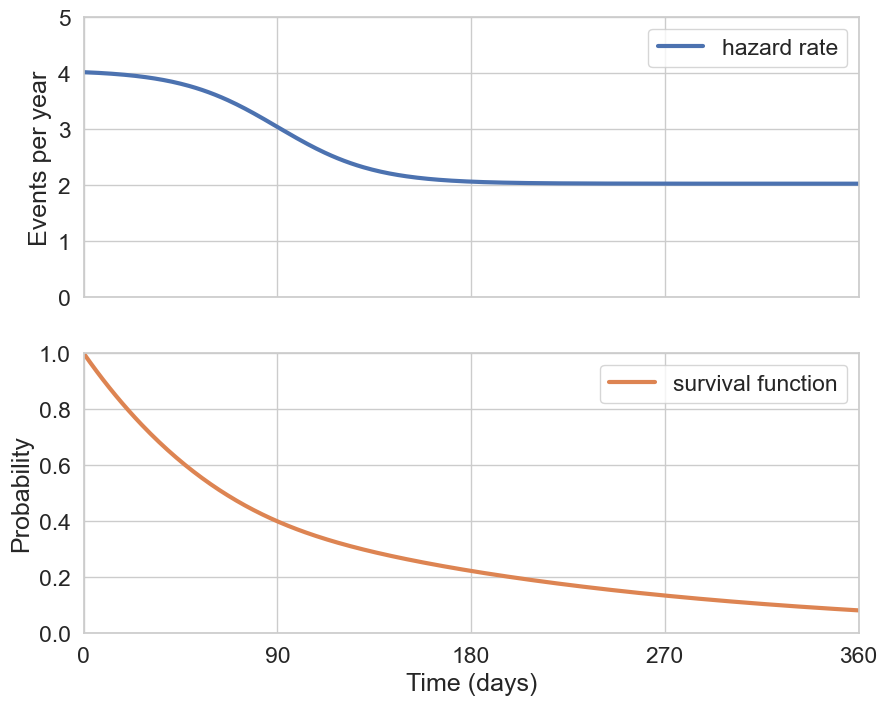

In [3]:
#| label: fig-survival
#| fig-cap: "Theoretical survival curve and hazard rate for toy problem"
#| include: true
#| echo: false

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
axes[0].plot(365 * hazard_rate, linewidth=3, label='hazard rate',  c=sns.color_palette()[0])
tmax = 360
axes[0].set_xlim([0, tmax])
axes[0].set_xlim([0, tmax])
axes[0].set_ylim([0, 5])
axes[0].set_xticks([0, 90, 180, 270, 360])
axes[0].set_ylabel('Events per year')
axes[0].legend()

axes[1].plot(survival_function, linewidth=3, label='survival function', c=sns.color_palette()[1])
axes[1].set_xlim([0, tmax])
axes[1].set_xlim([0, tmax])
axes[1].set_ylim([0, 1])
axes[1].set_xticks([0, 90, 180, 270, 360])
axes[1].set_ylabel('Probability')
axes[1].legend()
_ = axes[1].set_xlabel('Time (days)')

Let's now simulate 100 patients subject to the above survival curve and see that we can use the Kaplan-Meier approach to estimate the survival curve. In generating these data, we also include censoring, that is, patients which leave the study without experiencing an event. The censoring is completely at random with a constant rate.

In [4]:
#| include: true

def sample_survival_times(
    n_patients: int,
    survival_function: np.array) -> np.array:
    
    # sample survival times
    survival_samples = np.random.rand(n_patients)
    observation_time = len(survival_function)
    survival_times = observation_time - np.searchsorted(survival_function[::-1], survival_samples)    

    return survival_times
    
def generate_survival_data(
    n_patients: int,
    survival_function: np.array, 
    censor_rate: float) -> pd.DataFrame:

    # require a non-increasing survival function that begins at 1
    assert survival_function[0] == 1
    assert np.all(survival_function[:-1] >= survival_function[1:])

    # sample survival times
    survival_times = sample_survival_times(n_patients, survival_function)

    # apply censoring --
    # censoring is basically a competing survival process, in this case
    # with an assumed constant rate
    time = np.linspace(0, len(survival_function), len(survival_function) + 1)
    censoring_survival = np.exp(- censor_rate * time)
    censoring_times = sample_survival_times(n_patients, censoring_survival)
    
    patients = list(range(n_patients))
    time_to_event = np.minimum(survival_times, censoring_times)
    censoring_flag = np.argmin(np.vstack((survival_times, censoring_times)), axis=0)
    
    return pd.DataFrame.from_dict({
        'patient':patients,
        'event_time':time_to_event,
        'is_censored':censoring_flag
    })    

n_patients = 100
censor_rate = 1./180
cohort_1_events = generate_survival_data(n_patients, survival_function, censor_rate)
cohort_1_events

,patient,event_time,is_censored
0,0,155,0
1,1,69,0
2,2,23,0
3,3,8,0
4,4,155,1
...,...,...,...
95,95,40,1
96,96,40,0
97,97,87,1
98,98,10,0


## Kaplan-Meier Curve

In order to calculate the KM curve, we first aggregate the patient data by event time as follows:

In [5]:
#| include: true

def aggregate_events(patient_level_events: pd.DataFrame) -> pd.DataFrame:

    n_patients = len(patient_level_events)
    agg_events = patient_level_events.groupby('event_time').agg(
        n_events = ('is_censored', lambda x: len(x) - sum(x)),
        n_censored = ('is_censored', lambda x: sum(x)))
    agg_events.loc[0] = [0, 0]
    agg_events = agg_events.sort_values('event_time')
    agg_events.loc[:, 'at_risk'] = n_patients - \
        (agg_events['n_events'] + agg_events['n_censored']).shift(1).fillna(0).cumsum().astype(int)

    return agg_events

cohort_1_events_agg = aggregate_events(cohort_1_events)
cohort_1_events_agg


,n_events,n_censored,at_risk
event_time,,,
0,0,0,100
2,1,0,100
3,3,2,99
4,1,0,94
6,1,0,93
...,...,...,...
217,0,1,5
300,1,0,4
310,0,1,3


Now the calculation of the KM curve is exceedingly simple. In numpy, the calculation requires only two lines of code. The results of the calculation is shown below.

In [6]:
#| include: true
#| code-fold: true

def estimate_kaplan_meier_survival(
    n_events: np.array, 
    at_risk: np.array) -> np.array:
    
    km_estimate = 1 - n_events / at_risk
    km_estimate = km_estimate.cumprod()
    return km_estimate


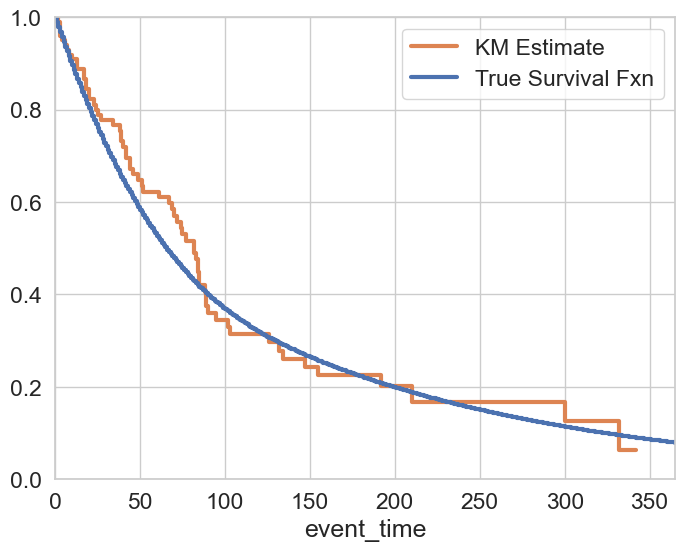

In [7]:
#| label: fig-survival-est
#| fig-cap: "Comparison of true survival curve to survival curve estimated with Kaplan-Meier."
#| include: true
#| echo: false
    
cohort_1_events_agg.loc[:, 'KM Estimate'] = estimate_kaplan_meier_survival(
    cohort_1_events_agg['n_events'], cohort_1_events_agg['at_risk'])
cohort_1_events_agg.loc[:, 'survival_input'] = survival_function[cohort_1_events_agg.index]

fig = plt.figure(figsize=(8,6))
ax = sns.lineplot(
    data=cohort_1_events_agg[['KM Estimate']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post',
    palette=sns.color_palette()[1:2]
)
ax.plot(
    survival_function, 
    drawstyle='steps-post', 
    linewidth=3, 
    label='True Survival Fxn', 
    color=sns.color_palette()[0]
)
ax.legend()
ax.set_ylim([0, 1])
_ = ax.set_xlim([0, 365])


As we can see, the estimated curve does not exactly match the theoretical curve. This difference is to be expected due to the finite number of samples we have.

## Log-Rank Test

To understand the log-rank test, let's now consider multiple (independent) samples of 100 patients. By construction, we know the survival curves for the two subgroups are identical, but we will see random fluctuations in the estimated KM curve.

In [8]:
def generate_km_curves_random_cohorts(n_patients, survival_function, censor_rate):
    
    cohort_1_events = generate_survival_data(n_patients, survival_function, censor_rate)
    cohort_2_events = generate_survival_data(n_patients, survival_function, censor_rate)
    split_agg_1 = aggregate_events(cohort_1_events)
    split_agg_2 = aggregate_events(cohort_2_events)
    split_agg_1.loc[:, 'KM Estimate (1)'] = estimate_kaplan_meier_survival(
        split_agg_1['n_events'], split_agg_1['at_risk'])
    split_agg_2.loc[:, 'KM Estimate (2)'] = estimate_kaplan_meier_survival(
        split_agg_2['n_events'], split_agg_2['at_risk'])
        
    return split_agg_1, split_agg_2

split_agg_1, split_agg_2 = generate_km_curves_random_cohorts(n_patients, survival_function, censor_rate)

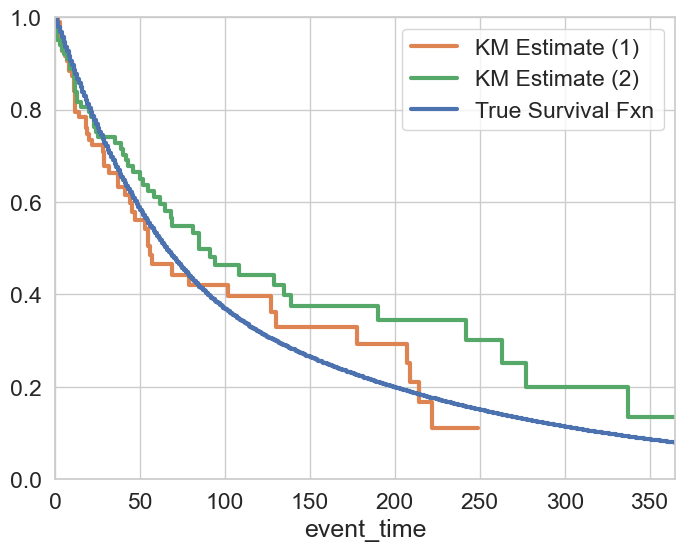

In [9]:
#| label: fig-survival-split
#| fig-cap: "Random variations in KM estimate due to finite sampling effects"
#| include: true
#| echo: false

fig = plt.figure(figsize=(8,6))
ax = sns.lineplot(
    data=split_agg_1[['KM Estimate (1)']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post',
    palette=sns.color_palette()[1:2]
)
ax = sns.lineplot(
    data=split_agg_2[['KM Estimate (2)']], 
    linewidth=3,
    dashes=False,
    drawstyle='steps-post',
    palette=sns.color_palette()[2:3]
)
ax.plot(
    survival_function, 
    drawstyle='steps-post', 
    linewidth=3, 
    label='True Survival Fxn',
    color=sns.color_palette()[0]
)
ax.legend()
ax.set_ylim([0, 1])
_ = ax.set_xlim([0, 365])


In [10]:
def compute_log_rank(split_agg_1, split_agg_2):
    
    df = split_agg_2.merge(
        split_agg_1,
        how='outer', 
        left_index=True, 
        right_index=True, 
        suffixes=['_1', '_2'])
    
    df.loc[:, 'at_risk_1'] = df['at_risk_1'].ffill()
    df.loc[:, 'at_risk_2'] = df['at_risk_2'].ffill()

    df.loc[:, 'n_events_1'] = df['n_events_1'].fillna(0)
    df.loc[:, 'n_events_2'] = df['n_events_2'].fillna(0)
    
    df.loc[:, 'n_events_all'] = df['n_events_1'] + df['n_events_2']
    df.loc[:, 'at_risk_all'] = df['at_risk_1'] + df['at_risk_2']
    
    df.loc[:, 'n_events_expected_1'] = df['n_events_all'] * df['at_risk_1'] / df['at_risk_all']
    df.loc[:, 'n_events_expected_2'] = df['n_events_all'] * df['at_risk_2'] / df['at_risk_all']
    
    df.loc[:, 'observed_minus_expected_1'] = df['n_events_expected_1'] - df['n_events_1']

    # what a crazy formula
    variance = (
        (df['at_risk_1'] * df['at_risk_2']) * \
        (df['n_events_1'] + df['n_events_2']) * \
        (df['at_risk_1'] + df['at_risk_2'] - (df['n_events_1'] + df['n_events_2'])) / (
        (df['at_risk_1'] + df['at_risk_2'])**2 * \
        (df['at_risk_1'] + df['at_risk_2'] - 1)
        )).sum()
    log_rank = df['observed_minus_expected_1'].sum()**2 / variance

    return df, log_rank


(0.0, 365.0)

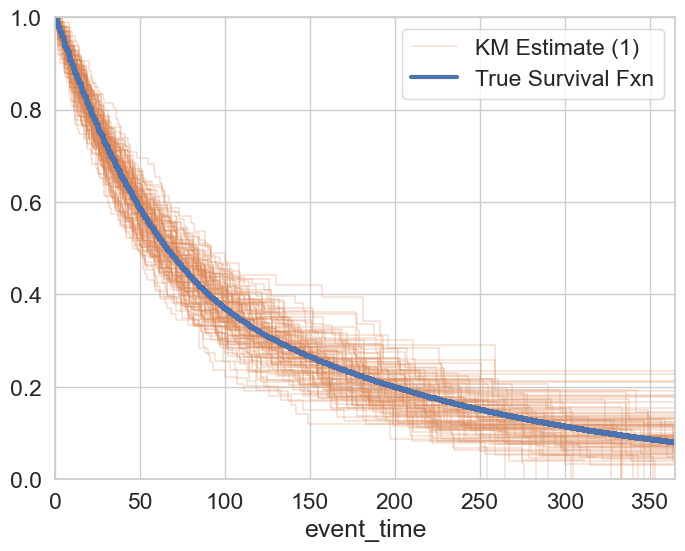

In [11]:
#| label: fig-main
#| class: preview-image
#| fig-cap: "An ensemble of random KM curves drawn from the same underlying population."
#| include: true

fig = plt.figure(figsize=(8,6))
lr = []
for _ in range(100):

    split_agg_1, split_agg_2 = generate_km_curves_random_cohorts(n_patients, survival_function, censor_rate)
    
    ax = sns.lineplot(
        data=split_agg_1[['KM Estimate (1)']], 
        linewidth=0.3,
        dashes=False,
        drawstyle='steps-post',
        palette=sns.color_palette()[1:2],
        ax=fig.gca()
    )
    ax.plot(
        survival_function, 
        drawstyle='steps-post', 
        linewidth=3, 
        label='True Survival Fxn',
        color=sns.color_palette()[0]
    )
# ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_ylim([0, 1])
ax.set_xlim([0, 365])


Above we show an ensemble of 100 random Kaplan-Meier curves drawn from the same underlying population. The plot shows the individual KM curves, each representing survival data from different random splits of the cohort. For comparison, we have drawn also the true survival function, and we see that variations in the estimated KM curve arise out of finite sampling effects. The variation in these estimated curves indicate the expected variation in the KM estimate under the null hypothesis that the the survival curves are the same. 

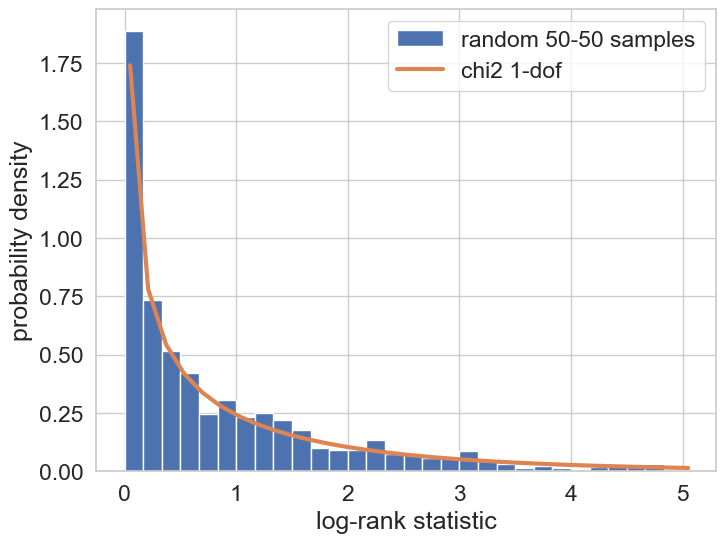

In [12]:
#| label: fig-logrank
#| fig-cap: "Distribution of log-rank statistic for random samples of 50 patients having the same survival curve."
#| include: true

lr = []
for _ in range(1000):
    split_agg_1, split_agg_2 = generate_km_curves_random_cohorts(n_patients, survival_function, censor_rate)
    df_log_rank, lr_stat = compute_log_rank(split_agg_1, split_agg_2)
    lr.append(lr_stat)
    
from scipy.stats import chi2
fig = plt.figure(figsize=(8,6))
_ = plt.hist(lr, bins=np.linspace(0, 5, 31), density=True, label='random 50-50 samples')
X = 0.05 + np.linspace(0, 5, 32)
y = [chi2.pdf(x, 1) for x in X]
plt.plot(X, y, linewidth=3, label='chi2 1-dof')
plt.xlabel('log-rank statistic')
plt.ylabel('probability density')
plt.legend()

Now for each of the ensemble pairs generated in the previous plot, we compute the log-rank statistics.  We see that the distribution of the log-rank statistics matches well a $\chi^2$ distribution with one degree-of-freedom.

To compute the log-rank statistic, we assume that events are distributed randomly between the two groups. For instance, if there are 3 events in a certain time period, 91 patients in group 1 and 90 patients in group 2, then we should expect on average there to be $3 * 91 / 181$ events in group 1 and $3 * 90 / 181$ events in group 2. See the table below.

In [13]:
#| include: true

df_log_rank[['n_events_1', 'at_risk_1',
       'n_events_2', 'at_risk_2',
       'n_events_all', 'at_risk_all', 'n_events_expected_1', 'observed_minus_expected_1']].head(10)

,n_events_1,at_risk_1,n_events_2,at_risk_2,n_events_all,at_risk_all,n_events_expected_1,observed_minus_expected_1
event_time,,,,,,,,
0,0.0,100.0,0.0,100.0,0.0,200.0,0.000000,0.000000
1,1.0,100.0,1.0,100.0,2.0,200.0,1.000000,0.000000
2,0.0,100.0,1.0,99.0,1.0,199.0,0.502513,0.502513
3,0.0,99.0,0.0,97.0,0.0,196.0,0.000000,0.000000
4,0.0,98.0,1.0,95.0,1.0,193.0,0.507772,0.507772
5,1.0,97.0,0.0,95.0,1.0,192.0,0.505208,-0.494792
6,0.0,97.0,0.0,94.0,0.0,191.0,0.000000,0.000000
7,2.0,96.0,0.0,92.0,2.0,188.0,1.021277,-0.978723
8,1.0,94.0,0.0,91.0,1.0,185.0,0.508108,-0.491892


Now taking the sum of the observed number of events minus the expected number of events, and dividing by an estimate for the variance, we arrive at the log-rank statistic (for details see [1]).

# Conclusion

In conclusion, we explored the sampling distribution of Kaplan-Meier curves and seen that sampling effects leads to variation in the observed KM curve. The log-rank tests measures when differences in KM curves are larger than one would expect by pure chance, when the underlying populations are the same.

# Further reading

[1] [Survival Analysis Self-Learning Book](http://www.uop.edu.pk/ocontents/survival-analysis-self-learning-book.pdf)